# Text classification with LSTM

The following notebook shows how to perform text classification with an LSTM, or Long Short Term Memory, network: a special case of an RNN.

Here we utilize learned embeddings, which we initialize with pretrained embeddings, specifically 50-dimensional GloVe.

In [32]:
import torch

In [35]:
vocab,embeddings = [],[]

with open('glove.6B.50d.txt','rt', encoding="utf8") as fi:
    full_content = fi.read() # read the file
    full_content = full_content.strip() # remove leading and trailing whitespace
    full_content = full_content.split('\n') # split the text into a list of lines

for i in range(len(full_content)):
    i_word = full_content[i].split(' ')[0] # get the word at the start of the line
    i_embeddings = [float(val) for val in full_content[i].split(' ')[1:]] # get the embedding of the word in an array
    # add the word and the embedding to our lists
    vocab.append(i_word)
    embeddings.append(i_embeddings)

# convert our lists to numpy arrays:
import numpy as np
vocab_npa = np.array(vocab)
embs_npa = np.array(embeddings)

Adding tokens and their corresponding embeddings to handle padding and unknown words:

In [36]:
# insert tokens for padding and unknown words into our vocab
vocab_npa = np.insert(vocab_npa, 0, '<pad>')
vocab_npa = np.insert(vocab_npa, 1, '<unk>')
print(vocab_npa[:10])

# make embeddings for these 2:
# -> for the '<pad>' token, we set it to all zeros
# -> for the '<unk>' token, we set it to the mean of all our other embeddings

pad_emb_npa = np.zeros((1, embs_npa.shape[1])) 
unk_emb_npa = np.mean(embs_npa, axis=0, keepdims=True) 

#insert embeddings for pad and unk tokens to embs_npa.
embs_npa = np.vstack((pad_emb_npa,unk_emb_npa,embs_npa))
print(embs_npa.shape)

['<pad>' '<unk>' 'the' ',' '.' 'of' 'to' 'and' 'in' 'a']
(400002, 50)


Our embedding layer should have dimensions =  ***number of words in vocab*** $\times$ ***number of dimensions in embedding***

In [37]:
import torch
my_embedding_layer = torch.nn.Embedding.from_pretrained(torch.from_numpy(embs_npa).float())

# sanity check
assert my_embedding_layer.weight.shape == embs_npa.shape
print(my_embedding_layer.weight.shape)

torch.Size([400002, 50])


In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split

# load train.csv into a pandas dataframe
# we can use any other NLP binary classfication problem here as long as
# there are only 2 columns: 'review' and 'label'
# where review contains text and label contains 0/1

df = pd.read_csv("ECE_C147_project/archive/yelp_review.csv")

df_new = df.drop(columns = ['review_id', 'user_id', 'business_id', 'date', 'useful', 'funny', 'cool'])
df_new['label'] = df_new.apply(lambda row: int(row.stars>=4), axis = 1)
#1: 4 or 5 stars, 0: <4 stars
df_new = df_new.drop(columns = ['stars'])
df_new = df_new.rename(columns={"text": "review"})

print(df_new.head())
df = df_new

train_prop = 0.7 # 70% for training set
test_prop = 0.2 # 20% for test set
val_prop = 0.1 # 10% for validation set

# split the data into training and validation sets
train_val_df, test_df = train_test_split(df, test_size=test_prop, shuffle=True, random_state=11)
df, val_df = train_test_split(train_val_df, test_size=val_prop/(train_prop+val_prop), shuffle=True, random_state=11)

# print the number of rows in each set
print(f"Train:       {len(df)} rows")
print(f"Test:        {len(test_df)} rows")
print(f"Validation:  {len(val_df)} rows")

Train:       43508 rows
Test:        12431 rows
Validation:  6216 rows


We want to be able to classify the above reviews, so that we can predict the label of a new review with our model.

First, we want to be turn our dataframe into an object of the Pytorch's Dataset class so we can easily split our data into batches and feed it to our neural network:

In [40]:
class LSTMDataset(torch.utils.data.Dataset):
    def __init__(self, df, vocab, max_seq_length, pad_token, unk_token):
        # make a list of our labels
        self.labels = df.label.tolist()

        # make a dictionary converting each word to its id in the vocab, as well
        # as the reverse lookup
        self.word2idx = {term:idx for idx,term in enumerate(vocab)}
        self.idx2word = {idx:word for word,idx in self.word2idx.items()} 
        
        self.pad_token,self.unk_token = pad_token,unk_token

        self.input_ids = [] 
        self.sequence_lens = [] 
        self.labels = []

        for i in range(df.shape[0]):
            # clean up each sentence and turn it into tensor containing the  
            # token ids of each word. Also add padding to make them all the 
            # same length as the longest sequence
            input_ids,sequence_len = self.convert_text_to_input_ids(
                df.iloc[i].review,
                pad_to_len = max_seq_length) 
            
            self.input_ids.append(input_ids.reshape(-1))
            self.sequence_lens.append(sequence_len)
            self.labels.append(df.iloc[i].label)
        
        #sanity checks
        assert len(self.input_ids) == df.shape[0]
        assert len(self.sequence_lens) == df.shape[0]
        assert len(self.labels) == df.shape[0]
    
    def convert_text_to_input_ids(self,text,pad_to_len):
        # truncate excess words (beyond the length we should pad to)
        words = text.strip().split()[:pad_to_len]

        # add padding till we've reached desired length 
        deficit = pad_to_len - len(words) 
        words.extend([self.pad_token]*deficit)

        # replace words with their id
        for i in range(len(words)):
            if words[i] not in self.word2idx:
                # if word is not in vocab, then use <unk> token
                words[i] = self.word2idx[self.unk_token] 
            else:
                # else find the id associated with the word 
                words[i] = self.word2idx[words[i]] 
        return torch.Tensor(words).long(),pad_to_len - deficit

    def __len__(self):
        # Make dataset compatible with len() function
        return len(self.input_ids)
    
    def __getitem__(self, i):
        # for the ith indexm return a dictionary containing id, length and label
        sample_dict = dict()
        sample_dict['input_ids'] = self.input_ids[i].reshape(-1)
        sample_dict['sequence_len'] = torch.tensor(self.sequence_lens[i]).long()
        sample_dict['labels'] = torch.tensor(self.labels[i]).type(torch.FloatTensor)
        return sample_dict

Defining the LSTM model:
 - In the above model, we used the functions pack_padded_sequence() and its inverse to pass input to the model
 - Packing sequences in this way is useful because despite having to add padding so we can split into batches easily, this allows us to skip processing the padding

In [41]:
class LSTMEncoder(torch.nn.Module):
    def __init__(self, config):
        super(LSTMEncoder, self).__init__()
        
        # use the pretrained embeddings and check whether or not we should
        # freeze embeddings from our config dict
        pretrained_embeddings = config['pretrained_embeddings'] if 'pretrained_embeddings' in config else None
        freeze_embeddings = config['freeze_embeddings'] if 'freeze_embeddings' in config else False
        if pretrained_embeddings is not None:
            # use pretrained embeddings
            self.vocab_size = pretrained_embeddings.shape[0]
            self.embedding_dim = pretrained_embeddings.shape[1]
            self.embedding = torch.nn.Embedding.from_pretrained(
                torch.from_numpy(pretrained_embeddings).float(),
                freeze=freeze_embeddings
                )
        else:
            # use randomly initialized embeddings
            assert 'vocab' in config and 'embedding_dim' in config
            self.vocab_size = config['vocab'].shape[0]
            self.embedding_dim = config['embedding_dim']
            if freeze_embeddings:
                # why would you do this?
                print(
                    'WARNING:Freezing Randomly Initialized Embeddings!!😭😭😭'
                    )
            self.embedding = torch.nn.Embedding(
                self.vocab_size,
                self.embedding_dim,
                freeze = freeze_embeddings
                )
        
        # store some values from the config 
        self.hidden_size = config['hidden_size']
        self.lstm_unit_cnt = config['lstm_unit_cnt']

        # initialize LSTM 
        self.lstm = torch.nn.LSTM(
            input_size = self.embedding_dim,
            hidden_size = self.hidden_size,
            num_layers = self.lstm_unit_cnt,
            
            # batch_first = T -> input dim are [batch x sentence x embedding]
            # batch_first = F -> input dim are [sentence x batch x embedding]
            batch_first = True,

            # if bidirectional is true, then the seqeunce is passed through in 
            # both forward and backward directions and the results are 
            # concatenated. Lookup bidirectional LSTMs for details.
            bidirectional = False
            )
        
        middle_nodes = int(self.hidden_size / 2)

        self.fc1 = torch.nn.Linear(in_features = self.hidden_size, out_features = middle_nodes)
        self.fc2 = torch.nn.Linear(in_features = middle_nodes, out_features = 1)
        self.relu = torch.nn.functional.relu
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, batch):
        x = batch['input_ids'].to(device) # lookup token ids for our inputs
        x_lengths = batch['sequence_len'] # lookup lengths of our inputs
        embed_out = self.embedding(x) # get the embeddings of the token ids

        # In pytorch, RNN's need a packed sequence object as input
        packed_input = torch.nn.utils.rnn.pack_padded_sequence(
            embed_out,
            x_lengths.tolist(),
            # use if sequences are sorted by length in the batch
            enforce_sorted = False, 
            batch_first = True
            )
        
        packed_out, (final_hidden_state, final_cell_state) = self.lstm(packed_input)

        # Inverse operation of pack_padded_sequence
        output,_ = torch.nn.utils.rnn.pad_packed_sequence(
            packed_out,
            batch_first = True
            )
            
        lstm_out = output[range(len(output)), x_lengths - 1, :self.hidden_size]

        fc1_out = self.fc1(lstm_out)
        fc1_out = self.relu(fc1_out)
        fc2_out = self.fc2(fc1_out)
        final_out = self.sigmoid(fc2_out)
        return final_out
    
    def get_embedding_dims(self):
        return self.vocab_size, self.embedding_dim

In [42]:
config = {
    #model configurations
    'batch_size':32,
    'max_seq_length':100,
    'lr':1e-4,
    'label_count':2,
    'dropout_prob':2e-1,
    'hidden_size':256,
    'lstm_unit_cnt':2,

    #embeddings configurations
    'pretrained_embeddings':embs_npa,
    'freeze_embeddings':True,
    'vocab':vocab_npa,
    'pad_token':'<pad>',
    'unk_token':'<unk>',

    #data
    'train_df': df, #TODO: set val and test to appropriate
    'val_df': val_df,
    'test_df': test_df,
}

In [43]:
from torch import nn, optim
from torch.utils.data import DataLoader

train_dataset = LSTMDataset(
    df = config['train_df'], 
    vocab = config['vocab'],
    max_seq_length = config['max_seq_length'],
    pad_token = config['pad_token'],
    unk_token = config['unk_token']
)
val_dataset = LSTMDataset(
    df = config['val_df'], 
    vocab = config['vocab'],
    max_seq_length = config['max_seq_length'],
    pad_token = config['pad_token'],
    unk_token = config['unk_token']
)
test_dataset = LSTMDataset(
    df = config['test_df'], 
    vocab = config['vocab'],
    max_seq_length = config['max_seq_length'],
    pad_token = config['pad_token'],
    unk_token = config['unk_token']
)

train_loader = DataLoader(train_dataset, batch_size = config['batch_size'], shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = config['batch_size'], shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = config['batch_size'], shuffle = True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTMEncoder(config)
model.to(device)
model.train()

loss_criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = config['lr'])

In [69]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def validation(model, val_loader):
    with torch.no_grad():
        all_outputs = []
        all_labels = []
        for data in val_loader:
            labels = data['labels'].to(device)
            outputs = model(data)
            all_outputs = all_outputs + torch.round(outputs.squeeze()).tolist()
            all_labels = all_labels + labels.tolist()
        
        accuracy = sum([i==j for i, j in zip(all_outputs, all_labels)]) / len(all_labels)
        f1 = f1_score(y_pred= all_outputs, y_true=all_labels)

        return accuracy, f1

def testing(model, test_loader):
    with torch.no_grad():
        all_outputs = []
        all_labels = []
        all_scores = []
        for data in test_loader:
            labels = data['labels'].to(device)
            outputs = model(data)
            all_scores = all_scores + (outputs.squeeze()).tolist()
            all_outputs = all_outputs + torch.round(outputs.squeeze()).tolist()
            all_labels = all_labels + labels.tolist()
        accuracy = sum([i==j for i, j in zip(all_outputs, all_labels)]) / len(all_labels)
        f1 = f1_score(y_pred= all_outputs, y_true=all_labels)
        roc = roc_auc_score(y_score= all_scores, y_true=all_labels)
        cm = confusion_matrix(all_labels, all_outputs)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap = 'magma')
        plt.show()
        print('Test Statistics:')
        print()
        print(f"Accuracy     : {accuracy}")
        print(f"F1 score     : {f1}")
        print(f"AUC ROC score: {roc}")
        return 

In [45]:
from tqdm.notebook import tqdm

epochs = 5
for epoch in range(1, epochs + 1):
  progress_bar = tqdm(train_loader, leave=False)
  losses = []
  accuracies = []
  total = 0
  for data in progress_bar:
    target = data['labels'].to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = loss_criterion(output.squeeze(), target)
    loss.backward()
    # torch.nn.utils.clip_grad_norm_(model.parameters(), 3)
    optimizer.step()
    accuracy = torch.sum(target == torch.round(output.squeeze())) / target.shape[0]

    losses.append(loss.item())
    accuracies.append(accuracy.item())
    total += 1

    progress_bar.set_description(f'Loss: {loss.item():.3f}, Train Accuracy: {accuracy:.3f}')
  
  val_accuracy, val_f1 = validation(model, val_loader)
  print(f'Epoch: {epoch}')
  print(f'Training   | Loss: {(sum(losses) / total):.4f} | Accuracy: {(sum(accuracies) / total):.2f}% ')
  print(f'Validation | F1:   {val_f1:.4f} | Accuracy: {val_accuracy:.2f}% ')

  0%|          | 0/1360 [00:00<?, ?it/s]

Epoch: 0
Training   | Loss: 0.6176 | Accuracy: 0.65% 
Validation | F1:   0.6849 | Accuracy: 0.70% 


  0%|          | 0/1360 [00:00<?, ?it/s]

Epoch: 1
Training   | Loss: 0.5736 | Accuracy: 0.71% 
Validation | F1:   0.7271 | Accuracy: 0.70% 


  0%|          | 0/1360 [00:00<?, ?it/s]

Epoch: 2
Training   | Loss: 0.5588 | Accuracy: 0.72% 
Validation | F1:   0.7015 | Accuracy: 0.73% 


  0%|          | 0/1360 [00:00<?, ?it/s]

Epoch: 3
Training   | Loss: 0.5387 | Accuracy: 0.73% 
Validation | F1:   0.7533 | Accuracy: 0.72% 


  0%|          | 0/1360 [00:00<?, ?it/s]

Epoch: 4
Training   | Loss: 0.5188 | Accuracy: 0.74% 
Validation | F1:   0.7089 | Accuracy: 0.74% 


Now we will test our model using the test dataset:

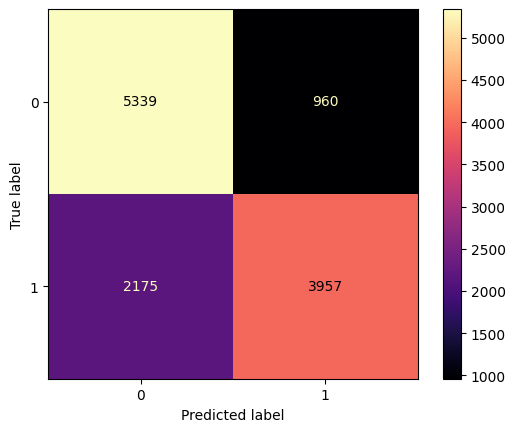

Test Statistics:

Accuracy     : 0.7478078996058242
F1 score     : 0.7162639152864514
AUC ROC score: 0.8385635612233877


In [70]:
testing(model, test_loader)